In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 6)
import numpy as np
import librosa, librosa.display, IPython.display as ipd
from tqdm import tqdm
import glob
import pandas as pd
import h5py
from sklearn import preprocessing
import pickle
np.random.seed(1515)

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config) 
    
import keras 
from keras.backend.tensorflow_backend import set_session
set_session(sess)  # set this TensorFlow session as the default session for Keras

from keras.layers import Input, Conv2D, MaxPooling2D, LSTM
from keras.layers import Dense, Flatten
from keras.layers.core import Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
#SET PATHS
dataspace = '/vol/vssp/datasets/audio01/UrbanSound8K/audio/'
projectspace = '/vol/vssp/AcousticEventsDetection/DLGdansk/UrbanSound/'

metadatafile = '/vol/vssp/datasets/audio01/UrbanSound8K/metadata/UrbanSound8K.csv'
metadata = pd.read_csv(metadatafile)

hdf5_path = os.path.join(projectspace,'dataset.hdf5') 
modelfolder = os.path.join(projectspace,'models')
scalerpath = os.path.join(projectspace,'scaler.pkl')

In [4]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))
y_test = np.array(hf.get('y_test'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [5]:
# SCALE THE DATA
scaler=pickle.load(open(scalerpath, 'rb'))

X_train_scaled = [scaler.transform(x.T) for x in X_train]
X_val_scaled = [scaler.transform(x.T) for x in X_val]
X_test_scaled = [scaler.transform(x.T) for x in X_test]

# CHANGE DIMENSION TO FIT KERAS
X_train = np.expand_dims(X_train_scaled, 3)
X_val = np.expand_dims(X_val_scaled, 3)
X_test = np.expand_dims(X_test_scaled, 3)

In [6]:
n_features = 40
n_frames=173

In [7]:
def build_cnn(n_frames=n_frames, n_features=n_features,  n_filters_cnn=48,
                     filter_size_cnn=(3, 3), pool_size_cnn=(2,2),
                     n_classes=10):

    # INPUT
    x = Input(shape=(n_frames, n_features,  1), dtype='float32')

    # CONV 1
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid', kernel_regularizer=l2(0.01),
               activation='relu')(x)
    y = MaxPooling2D(pool_size=pool_size_cnn, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # CONV 2
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size_cnn, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # CONV 3
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size_cnn, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # Flatten for dense layers
    y = Flatten()(y)
    #y = Dropout(0.5)(y)
    #y = Dense(n_dense_cnn, activation='relu')(y)

    y = Dropout(0.5)(y)
    y = Dense(n_classes, activation='sigmoid')(y)

    m = Model(inputs=x, outputs=y)
    return m

In [8]:
m = build_cnn(n_features=40,)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 173, 40, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 171, 38, 48)       480       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 19, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 85, 19, 48)        192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 83, 17, 48)        20784     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 8, 48)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 41, 8, 48)         192       
__________

In [9]:
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model_checkpoint = ModelCheckpoint(
    os.path.join(modelfolder, 'cnn_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5'),
    monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
callbacks = [early_stopping, model_checkpoint]

history = m.fit(x=X_train, y=y_train, batch_size=130,
                    epochs=200, verbose=True,
                    validation_split=0.0,                
                    callbacks=callbacks,
                    validation_data=(X_val, y_val), shuffle=True)

Train on 7079 samples, validate on 816 samples
Epoch 1/200
7079/7079 [==============================] - 8s 1ms/step - loss: 2.6604 - acc: 0.3813 - val_loss: 2.9737 - val_acc: 0.2034
Epoch 2/200
7079/7079 [==============================] - 5s 751us/step - loss: 2.0052 - acc: 0.5319 - val_loss: 3.1785 - val_acc: 0.1495
Epoch 3/200
7079/7079 [==============================] - 5s 737us/step - loss: 1.5943 - acc: 0.6589 - val_loss: 3.0685 - val_acc: 0.1409
Epoch 4/200
7079/7079 [==============================] - 5s 702us/step - loss: 1.3068 - acc: 0.7397 - val_loss: 3.4495 - val_acc: 0.1287
Epoch 5/200
7079/7079 [==============================] - 5s 771us/step - loss: 1.0839 - acc: 0.7911 - val_loss: 3.2370 - val_acc: 0.2733
Epoch 6/200
7079/7079 [==============================] - 5s 742us/step - loss: 0.9327 - acc: 0.8209 - val_loss: 3.6155 - val_acc: 0.3076
Epoch 7/200
7079/7079 [==============================] - 6s 791us/step - loss: 0.7828 - acc: 0.8592 - val_loss: 2.9468 - val_acc: 0.2

7079/7079 [==============================] - 5s 723us/step - loss: 0.2436 - acc: 0.9710 - val_loss: 2.2131 - val_acc: 0.7316
Epoch 61/200
7079/7079 [==============================] - 5s 747us/step - loss: 0.2356 - acc: 0.9702 - val_loss: 2.1806 - val_acc: 0.7010
Epoch 62/200
7079/7079 [==============================] - 5s 730us/step - loss: 0.2768 - acc: 0.9597 - val_loss: 1.7115 - val_acc: 0.7353
Epoch 63/200
7079/7079 [==============================] - 5s 760us/step - loss: 0.2673 - acc: 0.9621 - val_loss: 2.1841 - val_acc: 0.7304
Epoch 64/200
7079/7079 [==============================] - 5s 729us/step - loss: 0.2586 - acc: 0.9643 - val_loss: 2.3173 - val_acc: 0.7047
Epoch 65/200
7079/7079 [==============================] - 5s 731us/step - loss: 0.2499 - acc: 0.9692 - val_loss: 2.0894 - val_acc: 0.7194
Epoch 00065: early stopping


In [11]:
prediction = m.predict(X_test, batch_size=130, verbose=1)
y_predict=np.array([ np.argmax(p) for p in prediction])
y_test_label = np.array([np.argmax(y) for y in y_test])

837/837 [==============================] - 1s 688us/step


Accuracy: 0.76


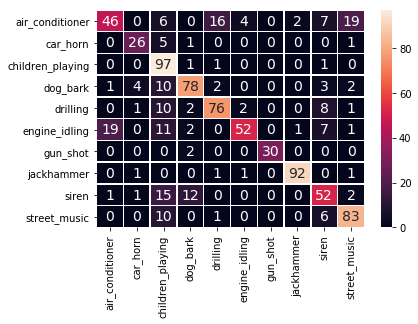

In [12]:
from sklearn.metrics import confusion_matrix
acc = np.sum(y_test_label==y_predict) / float(len(y_test_label))
print('Accuracy: {:.2f}'.format(acc))

cm = confusion_matrix(y_test_label, y_predict )
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, yticklabels=label_list,xticklabels=label_list)